# Espiral builts from semicircunferences



In [6]:
#Librerias
import numpy as np
import pylab as plt


from filon import cos_integral
from scipy.integrate import simps
from scipy import interpolate 
from scipy import integrate

## Distancia Espiral construida por semicircunferencias

In [2]:
n=narc =10
def pos(S,R0,dr):
        ss= np.zeros(n)
        rr= np.zeros(n)
        for i in range(n):
            ss[i] = (i+1)*np.pi*(R0+0.5*i*dr)
            rr[i] = R0 + i*dr
       # print(ss,rr)
        i=0
        phi=0
        while i <= n:
            if S > ss[i]:
                i=i+1
            else:
                sss= abs(S-ss[i])
                phi= np.pi - sss/rr[i] 
                R=rr[i]
                if i % 2 == 0:          
                    x=R*np.cos(phi)
                    y=R*np.sin(phi)
                elif i%2 == 1:
                    phi= phi+ np.pi          
                    x=R*np.cos(phi)+dr
                    y=R*np.sin(phi)
                return [x,y,R]

def distancia(s,sd,R0,dr):
    xs,ys,Rs=pos(s,R0,dr)
    xd,yd,Rd=pos(sd,R0,dr)
    return [np.sqrt((xs-xd)**2+(ys-yd)**2+0.25),Rs]

# Calculation of the Fourier coefficients in Vpot(x) the Fourier series expansion

### Coefic de Vpot: $\frac{1}{S_f} \int \limits_0^{S_f} V_{pot}(s)\cos\left(\frac{k\pi}{S_f}s\right) \mathrm{d}s$
####  Filon.cos_integral calculates the integral:  $ \int_{x_0}^{2n\Delta x} f(x) \cos(k x) dx $

##### $COEF= \int\limits_0 ^{SF} VS\cos\left(\frac{k\pi}{S_f}s\right) \mathrm{d}s = \int\limits_0 ^{SF}  VS\cos\left( \, \mathrm{kindex}\,  s\right) \mathrm{d}s  $


### Effective potential:$V_{pot}(x,y,z)= V_{pot}(s) = -\frac{1}{4R_s^2} -\frac{2}{\sqrt{(xs-xd)^2 +(ys-yd)^2 + 0.025}}$


In [3]:
def Vpot(s,sd,Rr0,DR):
    Red,Rs=distancia(s,sd,Rr0,DR)
    ro= Rs
    Vpot= -0.25/(Rs**2) - 2.0/Red**2
    return Vpot

### Spiral parameters

In [4]:

def int_vpot(sf,R0,DR,SD_grid):
    Ndonor= len(SD_grid)
    SE_grid = np.linspace(0, sf, Nelectron)  # Electron position
    SD_SF = np.zeros(Ndonor)
    ds= sf/(Nelectron)
#-------------------   # Potential#  --------------------------------
    VS=np.zeros(shape=(Ndonor,Nelectron)) #ARRAY 3D nn--->electric Fields ND---> Fourier COEF     
    kindex=np.zeros(Nelectron)
    for j  in range(0, Ndonor):
        sd = SD_grid[j]
        SD_SF[j] = sd/sf
        #print(SD_SF[j])
        for k in range( 0,Nelectron):
            se = SE_grid[k]
            kindex[k]= (k*np.pi/sf)
            VS[j,k] = Vpot(se,sd,R0,DR)
    return VS,kindex,ds,SE_grid,SD_SF


In [5]:
def coef(VS,ds,kindex,sf):
    COEF=np.zeros((Ndonor,Nelectron))
    for j in range(0,Ndonor):
        COEF[j,:]=(1/sf)*(cos_integral(VS[j,:],ds, kindex, x0=0.0, axis=0))
    return COEF

### Formación de Matriz $ A_{mn}= \frac{\pi^2 n^2}{S_F^2} \delta _{n,n'} +  I ( | n-n'|) - I( n+ n') $

##### $ I(k)= \frac{1}{S_F} \int \limits_0 ^{SF} V_{pot}(S) \cos\left(\frac{k\pi}{S_f}s\right) \mathrm{d}s $

In [6]:
def schr(COEF,sf):
    nd=int(Nelectron/2)
    AR=np.zeros(shape=(nd,nd))
    eigenvalues = np.zeros(shape=(Ndonor,nd))
    eigenvectors = np.zeros(shape=(Ndonor,nd,nd))
    for s in range(0,Ndonor):
        for k in range(0,nd):
            for k1 in range(0,nd):
                ka=abs(k-k1)
                AR[k,k1]= 0.5*(COEF[s,ka] - COEF[s,k+k1])
                if (k == k1):
                    AR[k,k1]=AR[k,k1]+(np.pi*k/sf)**2
        eigenvalues[s],eigenvectors[s] = np.linalg.eigh(AR)
    return eigenvalues,eigenvectors

## Making the electronic density of states DOS

In [7]:
def DOS(s,Ee):
    nEe= int(Nelectron/2) # #Number of eigenvalues
    Np = 200  #Number of points to graph 
    F = np.zeros((Np,Ndonor)) 
    X = np.zeros(Np)
    Emin = -4.0 #np.min(Ee)
    Emax = 0.0 #np.max(Ee)
    Energy_grid = np.linspace(Emin, Emax,Np)
    s=0.03
    def fg(x,x0,s):
        return (s/((x-x0)**2+s**2))/np.pi
    for i in range(0,Np):
        x = Energy_grid[i]
        X[i]= x
        for k in range(0,nEe): 
            x0=Ee[:,k]
            F[i,:] = F[i,:] + fg(x,x0,s)
    return X,F

In [43]:

R0_a= 2   # Initial Radius of  de Curvature
R0_b= 5
R0_c= 2

DR_a=0.1  # Raise in semi-arc
DR_b=0.1
DR_c=0.2 

sf_a=narc*np.pi*(R0_a+0.5*(narc-1)*DR_a)  
sf_b=narc*np.pi*(R0_b+0.5*(narc-1)*DR_b)
sf_c=narc*np.pi*(R0_c+0.5*(narc-1)*DR_c) 

Nelectron=501
SD_grid_a=  np.array([0.2*sf_a,0.5*sf_a,0.85*sf_a ]) #np.linspace(0, sf_a, 20)
SD_grid_b= np.array([0.2*sf_b,0.5*sf_b,0.85*sf_b ]) # np.linspace(0, sf_a, 20)
SD_grid_c= np.array([0.2*sf_c,0.5*sf_c,0.85*sf_c ])
Ndonor= len(SD_grid_a)

In [44]:
VSa,kindexa,dsa,SE_grid_a,SD_SF_1 = int_vpot(sf_a,R0_a,DR_a, SD_grid_a)
VSb,kindexb,dsb,SE_grid_b,SD_SF_2 = int_vpot(sf_b,R0_b,DR_b, SD_grid_b)
VSc,kindexc,dsc,SE_grid_c,SD_SF_3 = int_vpot(sf_c,R0_c,DR_c, SD_grid_c)
#-------------------------------------------------
COEFa=coef(VSa,dsa,kindexa,sf_a)
COEFb=coef(VSb,dsb,kindexb,sf_b)
COEFc=coef(VSc,dsc,kindexc,sf_c)
#-------------------------------------------------
Ee1, VecR1 = schr(COEFa,sf_a)
Ee2, VecR2 = schr(COEFb,sf_b)
Ee3, VecR3 = schr(COEFc,sf_c)
#-------------------------------------------------
s=0.03
X,F1= DOS(s,Ee1)
X,F2= DOS(s,Ee2)
X,F3= DOS(s,Ee3)


In [45]:
sf_b

171.21679962064374

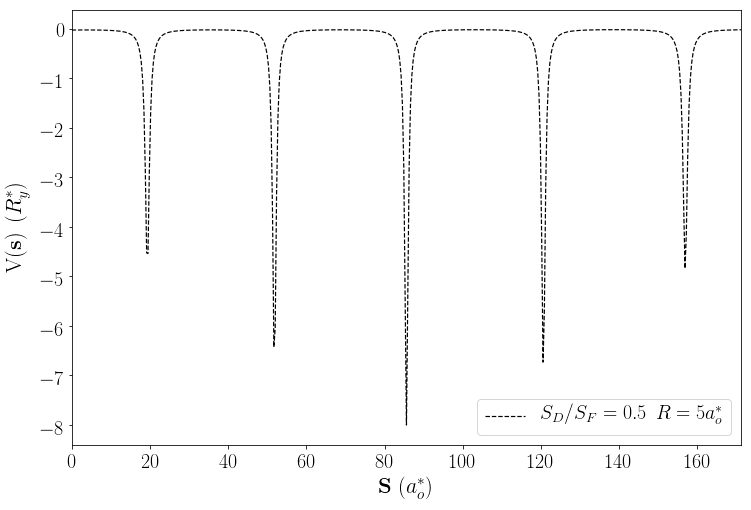

In [52]:

x1=  SE_grid_a #1 - SD_grid_1  #Long_arc
x2=  SE_grid_b #- SD_grid_2
y1= VSa[1,:]  
y2= VSb[1,:]
#y3= VSa[2,:]

fig=plt.figure(figsize=(12,8) )#pi=1000)
ax = fig.add_subplot(1, 1, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.xlabel(r'\textbf{S}  ($ a_o^*$)',labelpad=10,fontsize=22,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'V(\textbf{s})\,  ($R_y^*$)',labelpad=8,fontsize=22,fontweight='bold', horizontalalignment ='center')



#plt.plot(x1,y1,linestyle='-',label= '\, $S_D/S_F = 0.5   \, R= 2 a_o^*$ ', color= 'b' ,linewidth=1.2)
#plt.plot(x2,y2,linestyle='--',label= ' $S_D/S_F = 0.5 \, \Delta R= 0.2$ ',linewidth=1.2, color= 'black'  )
plt.plot(x2,y2,linestyle='--',label= ' $S_D/S_F = 0.5 \, \ R= 5 a_o^*$ ',linewidth=1.2, color= 'black'  )

#plt.axvline(x1.max(), color='black', linestyle='-',linewidth=0.6)
#plt.plot(x2,VSb[0,:],linestyle='-',label= ' $S_D/S_F = 0.63 $ $R = 5 a_o^* \, \Delta R= 0.1$ ',linewidth=1.2, color= 'black'  )

#plt.plot(x1,y3)
#ax.set_xlim(x1.min(), x1.max())
ax.set_xlim(x2.min(), x2.max())
#ax.set_ylim(y2.min(),y2.max() )

plt.legend(loc=(4), fontsize=20)
#plt.legend(('Valores exactos', "Aproximaci$\'{o}$n", ' Radio de Curvatura ($a_o^* $)'), loc=(0), fontsize=15)
#plt.savefig('Vr2-dr.png',format='png', dpi=1000,bbox_inches="tight")
#plt.savefig('vr2-dr.pdf',format='pdf', dpi=1000,bbox_inches="tight")

plt.savefig('VR05.png',format='png', dpi=1000,bbox_inches="tight")
plt.savefig('vR05.pdf',format='pdf', dpi=1000,bbox_inches="tight")
#plt.savefig('VrR0-1.png',format='png', dpi=1000,bbox_inches="tight")
#plt.savefig('vrR0-1.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

##### len(SE_grid_a)

In [144]:
# donor positions
vs1,dkindex1,dds1,dSE_grid_1,dSD_SF_1 = int_vpot(sf_1,R0_1,DR_1,Ndonor)
vs2,dkindex2,dds2,dSE_grid_2,dSD_SF_2 = int_vpot(sf_2,R0_2,DR_1,Ndonor)
#-------------------------------------------------
dCOEF1=coef(vs1,dds1,dkindex1,sf_1)
dCOEF2=coef(vs2,dds2,dkindex2,sf_2)
#COEF3=coef(VS3,ds3,kindex3,sf_3)
#-------------------------------------------------
dEe1, dVecR1 = schr(dCOEF1,sf_1)
dEe2, dVecR2 = schr(dCOEF2,sf_2)
#Ee3, VecR3 = schr(COEF3,sf_3)
#-------------------------------------------------
s=0.03
dX,dF1= DOS(s,dEe1)
dX,dF2= DOS(s,dEe2)
#X,F3= DOS(s,Ee3)


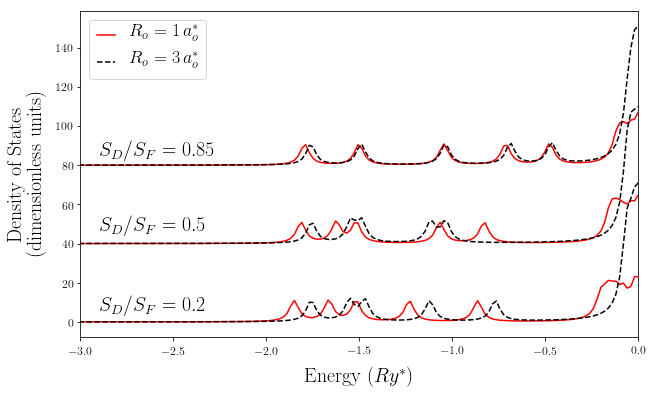

In [138]:
# Instantiate figure and plot

fig = plt.figure( figsize=(10,6) )
#plt.figure(1)

ax = fig.add_subplot(111)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlim(-3,0)
#ax.xaxis.set_tick_params(labelsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
R1 = ax.plot(X,F1[:,0], color= 'red',label='$R_o= 1 \, a_o^*$')
ax.plot( X,F1[:,1] + 40,X, F1[:,2] + 2*40, color= 'red')
ax.plot(X,F2[:,0], label='$R_o= 3 \, a_o^*$',color= 'black', linestyle='--')
ax.plot(X,F2[:,1] + 40,X, F2[:,2] + 2*40, color= 'black', linestyle='--')
plt.annotate('$S_D/S_F = 0.2 $', xy=(100, 80), xycoords='figure points',fontsize=20)
plt.annotate('$S_D/S_F = 0.5 $ ', xy=(100, 160), xycoords='figure points',fontsize=20)
plt.annotate('$S_D/S_F = 0.85 $', xy=(100, 235), xycoords='figure points',fontsize=20)
plt.xlabel(r'Energy ($Ry^*$) ', labelpad=10,fontsize=20,fontweight='bold', horizontalalignment='center')           
plt.ylabel(r'Density of States \\(dimensionless units)',labelpad=10,fontsize=20,fontweight='bold', horizontalalignment ='center')  
leg1 = ax.legend(loc='upper left', handlelength=1, fontsize=18)

#plt.savefig('DOS_dr0-1.pdf',format='pdf', dpi=1000,bbox_inches="tight")
#plt.savefig('DOS_dr0-1.png',format='png', dpi=1000,bbox_inches="tight")

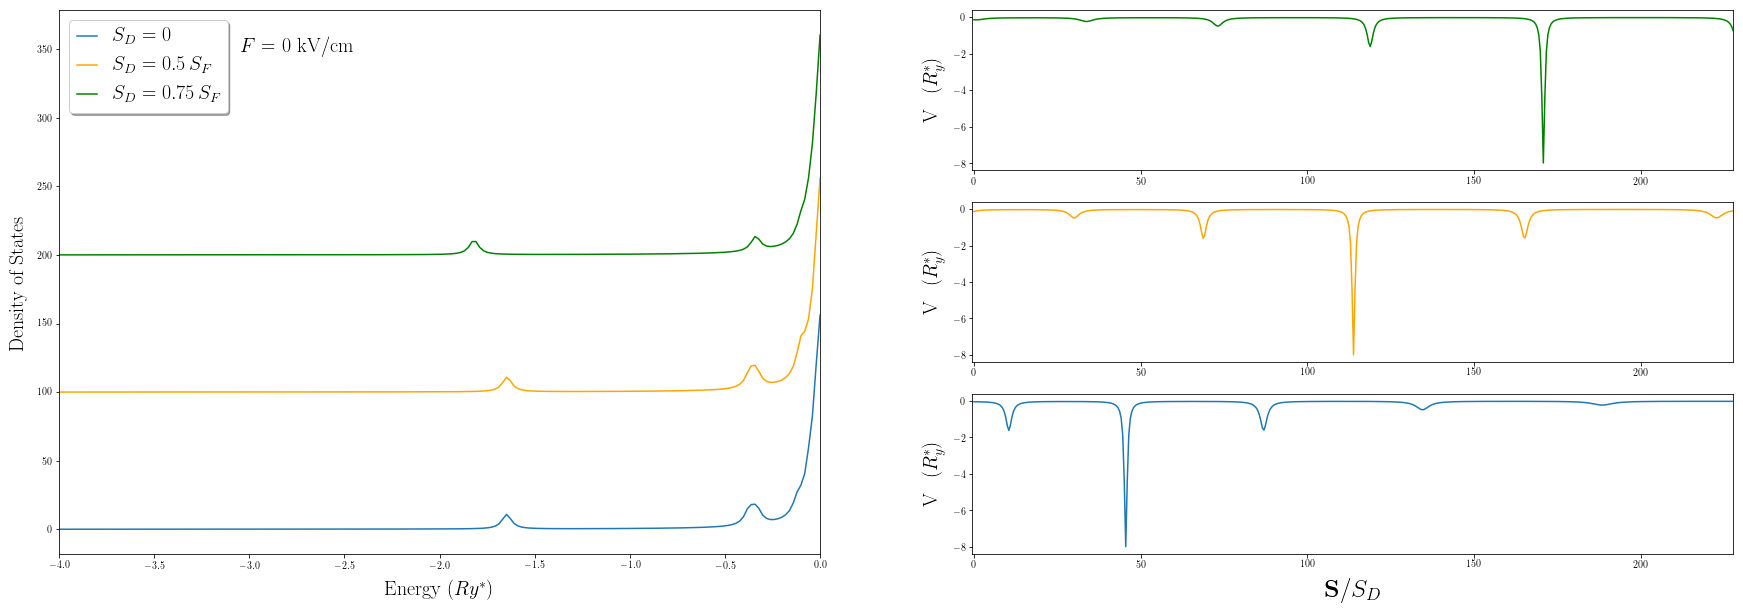

In [71]:

fig= plt.figure(figsize=[30,10])

plt.subplot(121)
#plt.ylim(-2, 75)
plt.xlim(-4, 0)
plt.plot(X,F[:,0,0]) 
plt.plot(X,F[:,1,0]+ 100, color='orange')
plt.plot(X,F[:,2,0]+ 200, color='green')
plt.annotate(r'$F$ = 0 kV/cm ', xy=(240, 560), xycoords='figure points',fontsize=20)
#plt.annotate('$\\theta = \pi$ ', xy=(235, 540), xycoords='figure points',fontsize=20)
#,marker='o',markersize=0.7,linestyle='')
#plt.title('Caso: $R_0= 1 a_0^*$, $\Delta= 0.1 a_0^*$',loc='center',fontsize=20)
plt.xlabel(r'Energy ($Ry^*$) ', labelpad=10,fontsize=20,fontweight='bold', horizontalalignment='center')           
plt.ylabel(r'Density of States',labelpad=10,fontsize=20,fontweight='bold', horizontalalignment ='center')     
plt.legend(('$S_D=0$', '$S_D=0.5 \, S_F$', '$S_D=0.75 \, S_F$'), shadow=True, loc=(2), handlelength=1, fontsize=20)


plt.subplot(322)
#plt.ylim(-13, 0)
plt.xlim(-0.5, SF)
#plt.title('$V_{pot}$',loc='center',fontsize=20)
plt.plot( SE_grid,  VS[0,2,:], color='green' )
plt.ylabel(r'V \,  ($R_y^*$)',labelpad=6,fontsize=20,fontweight='bold', horizontalalignment ='center')


plt.subplot(324)
#plt.ylim(-13, 0)
plt.xlim(-0.5, SF)
plt.plot( SE_grid,  VS[0,1,:], color='orange' )
plt.ylabel(r'V \,  ($R_y^*$)',labelpad=6,fontsize=20,fontweight='bold', horizontalalignment ='center')

# SD=0
plt.subplot(326)
#plt.ylim(-14, 0)
plt.xlim(-0.5, SF)
plt.plot( SE_grid,  VS[0,0,:] )

plt.xlabel(r'\textbf{S}/\textbf{$S_D$}',labelpad=10,fontsize=25,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'V \,  ($R_y^*$)',labelpad=6,fontsize=20,fontweight='bold', horizontalalignment ='center')

plt.savefig('DOS-PotR5.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.savefig('DOS-PotR5.png',format='png', dpi=1000,bbox_inches="tight")

 # Energy Position

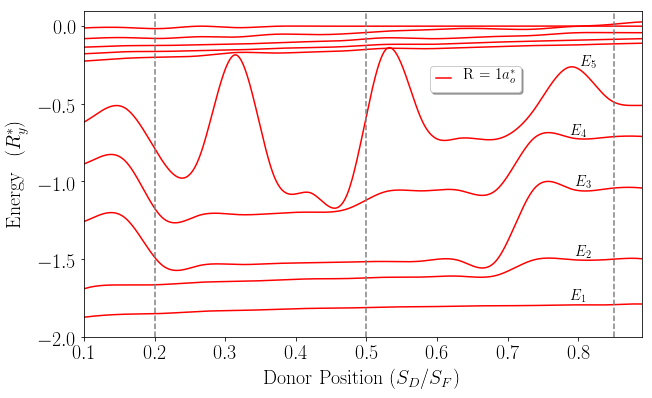

In [222]:
x =  dSD_SF_1

y0 =  dEe1[:,0]
y1 =  dEe1[:,1]
y2 =  dEe1[:,2]
y3 =  dEe1[:,3]
y4 =  dEe1[:,4]
y5 =  dEe1[:,5]
y6 =  dEe1[:,6]
y7 =  dEe1[:,7]
y8 =  dEe1[:,8]
y9 =  dEe1[:,9]

t0, c0, k0 = interpolate.splrep(x, y0, s=0, k=3)
t1, c1, k1 = interpolate.splrep(x, y1, s=0, k=3)
t2, c2, k2 = interpolate.splrep(x, y2, s=0, k=3)
t3, c3, k3 = interpolate.splrep(x, y3, s=0, k=3)
t4, c4, k4 = interpolate.splrep(x, y4, s=0, k=3)
t5, c5, k5 = interpolate.splrep(x, y5, s=0, k=3)
t6, c6, k6 = interpolate.splrep(x, y6, s=0, k=3)
t7, c7, k7 = interpolate.splrep(x, y7, s=0, k=3)
t8, c8, k8 = interpolate.splrep(x, y8, s=0, k=3)
t9, c9, k9 = interpolate.splrep(x, y9, s=0, k=3)


N = 1000
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

spline0 = interpolate.BSpline(t0, c0, k0, extrapolate=False)
spline1 = interpolate.BSpline(t1, c1, k1, extrapolate=False)
spline2 = interpolate.BSpline(t2, c2, k2, extrapolate=False)
spline3 = interpolate.BSpline(t3, c3, k3, extrapolate=False)
spline4 = interpolate.BSpline(t4, c4, k4, extrapolate=False)
spline5 = interpolate.BSpline(t5, c5, k5, extrapolate=False)
spline6 = interpolate.BSpline(t6, c6, k6, extrapolate=False)
spline7 = interpolate.BSpline(t7, c7, k7, extrapolate=False)
spline8 = interpolate.BSpline(t8, c8, k8, extrapolate=False)
spline9 = interpolate.BSpline(t9, c9, k9, extrapolate=False)


fig=plt.figure(figsize=(10,6) )#pi=1000)
ax = fig.add_subplot(1, 1, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.xlabel(r'Donor Position (\textbf{$S_D$}/\textbf{$S_F$})',labelpad=8,fontsize=20,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'Energy \,  ($R_y^*$)',labelpad=8,fontsize=20,fontweight='bold', horizontalalignment ='center')


plt.xlim(0.1,0.89)
plt.ylim(-2,0.1)

#plt.annotate('$\\theta\,   = \, \, \pi $', xy=(150, 85), xycoords='figure points',fontsize=24)

plt.annotate(r'\textbf{$E_1$}', xy=(570, 95), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_2$}', xy=(575, 140), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_3$}', xy=(575, 210), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_4$}', xy=(570, 260), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_5$}', xy=(580, 330), xycoords='figure points',fontsize=15)

#plt.title('$Caso: R_0= 1 a_0^*$, $\Delta= 0.1 a_0^*$',loc='center',fontsize=20)

plt.plot(xx, spline0(xx), label=' R = $1 a_o^*$', color='r')
plt.plot(xx, spline1(xx), color='r')
plt.plot(xx, spline2(xx), color='r')
plt.plot(xx, spline3(xx), color='r')
plt.plot(xx, spline4(xx), color='r')
plt.plot(xx, spline5(xx), color='r')
plt.plot(xx, spline6(xx), color='r')
plt.plot(xx, spline7(xx), color='r')
plt.plot(xx, spline8(xx), color='r')
plt.plot(xx, spline9(xx), color='r')
plt.axvline(0.2, color='grey', linestyle='--')
plt.axvline(0.5, color='grey', linestyle='--')
plt.axvline(0.85, color='grey', linestyle='--')

#plt.grid()
#plt.legend(loc='best')
plt.legend(shadow=True, loc=(0.62,0.75), handlelength=1, fontsize=15)


plt.savefig('1E_Sdr01.png',format='png', dpi=1000,bbox_inches="tight")
plt.savefig('1E_Sdr01.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

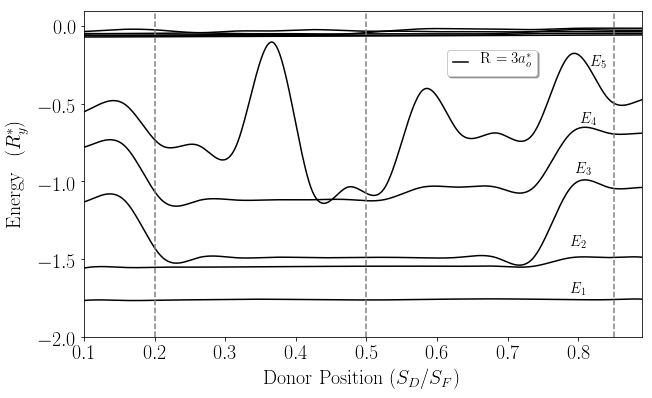

In [224]:
x =  dSD_SF_2

y0 =  dEe2[:,0]
y1 =  dEe2[:,1]
y2 =  dEe2[:,2]
y3 =  dEe2[:,3]
y4 =  dEe2[:,4]
y5 =  dEe2[:,5]
y6 =  dEe2[:,6]
y7 =  dEe2[:,7]
y8 =  dEe2[:,8]
y9 =  dEe2[:,9]

t0, c0, k0 = interpolate.splrep(x, y0, s=0, k=3)
t1, c1, k1 = interpolate.splrep(x, y1, s=0, k=3)
t2, c2, k2 = interpolate.splrep(x, y2, s=0, k=3)
t3, c3, k3 = interpolate.splrep(x, y3, s=0, k=3)
t4, c4, k4 = interpolate.splrep(x, y4, s=0, k=3)
t5, c5, k5 = interpolate.splrep(x, y5, s=0, k=3)
t6, c6, k6 = interpolate.splrep(x, y6, s=0, k=3)
t7, c7, k7 = interpolate.splrep(x, y7, s=0, k=3)
t8, c8, k8 = interpolate.splrep(x, y8, s=0, k=3)
t9, c9, k9 = interpolate.splrep(x, y9, s=0, k=3)


N = 1000
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

spline0 = interpolate.BSpline(t0, c0, k0, extrapolate=False)
spline1 = interpolate.BSpline(t1, c1, k1, extrapolate=False)
spline2 = interpolate.BSpline(t2, c2, k2, extrapolate=False)
spline3 = interpolate.BSpline(t3, c3, k3, extrapolate=False)
spline4 = interpolate.BSpline(t4, c4, k4, extrapolate=False)
spline5 = interpolate.BSpline(t5, c5, k5, extrapolate=False)
spline6 = interpolate.BSpline(t6, c6, k6, extrapolate=False)
spline7 = interpolate.BSpline(t7, c7, k7, extrapolate=False)
spline8 = interpolate.BSpline(t8, c8, k8, extrapolate=False)
spline9 = interpolate.BSpline(t9, c9, k9, extrapolate=False)


fig=plt.figure(figsize=(10,6) )#pi=1000)
ax = fig.add_subplot(1, 1, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

plt.xlabel(r'Donor Position (\textbf{$S_D$}/\textbf{$S_F$})',labelpad=8,fontsize=20,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'Energy \,  ($R_y^*$)',labelpad=8,fontsize=20,fontweight='bold', horizontalalignment ='center')


plt.xlim(0.1,0.89)
plt.ylim(-2,0.1)

#plt.annotate('$\\theta\,   = \, \, \pi $', xy=(150, 85), xycoords='figure points',fontsize=24)

plt.annotate(r'\textbf{$E_1$}', xy=(570, 102), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_2$}', xy=(570, 150), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_3$}', xy=(575, 223), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_4$}', xy=(580, 272), xycoords='figure points',fontsize=15)
plt.annotate(r'\textbf{$E_5$}', xy=(590, 330), xycoords='figure points',fontsize=15)

#plt.title('$Caso: R_0= 1 a_0^*$, $\Delta= 0.1 a_0^*$',loc='center',fontsize=20)

plt.plot(xx, spline0(xx), label='R $ = 3a^*_{o}$', color='black')
plt.plot(xx, spline1(xx), color='black')
plt.plot(xx, spline2(xx), color='black')
plt.plot(xx, spline3(xx), color='black')
plt.plot(xx, spline4(xx), color='black')
plt.plot(xx, spline5(xx), color='black')
plt.plot(xx, spline6(xx), color='black')
plt.plot(xx, spline7(xx), color='black')
plt.plot(xx, spline8(xx), color='black')
plt.plot(xx, spline9(xx), color='black')
plt.axvline(0.2, color='grey', linestyle='--')
plt.axvline(0.5, color='grey', linestyle='--')
plt.axvline(0.85, color='grey', linestyle='--')

#plt.grid()
plt.legend(shadow=True, loc=(0.65,0.8), handlelength=1, fontsize=15)

plt.savefig('3E_Sdr01.png',format='png', dpi=1000,bbox_inches="tight")
plt.savefig('3E_Sdr01.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

In [179]:
SD_SF_1

array([0.05263158, 0.10526316, 0.15789474, 0.21052632, 0.26315789,
       0.31578947, 0.36842105, 0.42105263, 0.47368421, 0.52631579,
       0.57894737, 0.63157895, 0.68421053, 0.73684211, 0.78947368,
       0.84210526, 0.89473684, 0.94736842, 1.        , 0.        ])

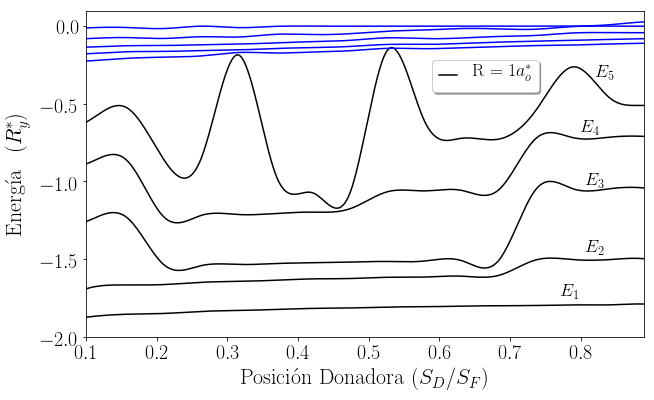

In [228]:
x =  SD_SF_1

y0 =  Ee1[:,0]
y1 =  Ee1[:,1]
y2 =  Ee1[:,2]
y3 =  Ee1[:,3]
y4 =  Ee1[:,4]
y5 =  Ee1[:,5]
y6 =  Ee1[:,6]
y7 =  Ee1[:,7]
y8 =  Ee1[:,8]
y9 =  Ee1[:,9]

t0, c0, k0 = interpolate.splrep(x, y0, s=0, k=3)
t1, c1, k1 = interpolate.splrep(x, y1, s=0, k=3)
t2, c2, k2 = interpolate.splrep(x, y2, s=0, k=3)
t3, c3, k3 = interpolate.splrep(x, y3, s=0, k=3)
t4, c4, k4 = interpolate.splrep(x, y4, s=0, k=3)
t5, c5, k5 = interpolate.splrep(x, y5, s=0, k=3)
t6, c6, k6 = interpolate.splrep(x, y6, s=0, k=3)
t7, c7, k7 = interpolate.splrep(x, y7, s=0, k=3)
t8, c8, k8 = interpolate.splrep(x, y8, s=0, k=3)
t9, c9, k9 = interpolate.splrep(x, y9, s=0, k=3)


N = 1000
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

spline0 = interpolate.BSpline(t0, c0, k0, extrapolate=False)
spline1 = interpolate.BSpline(t1, c1, k1, extrapolate=False)
spline2 = interpolate.BSpline(t2, c2, k2, extrapolate=False)
spline3 = interpolate.BSpline(t3, c3, k3, extrapolate=False)
spline4 = interpolate.BSpline(t4, c4, k4, extrapolate=False)
spline5 = interpolate.BSpline(t5, c5, k5, extrapolate=False)
spline6 = interpolate.BSpline(t6, c6, k6, extrapolate=False)
spline7 = interpolate.BSpline(t7, c7, k7, extrapolate=False)
spline8 = interpolate.BSpline(t8, c8, k8, extrapolate=False)
spline9 = interpolate.BSpline(t9, c9, k9, extrapolate=False)


fig=plt.figure(figsize=(10,6) )#pi=1000)
ax = fig.add_subplot(1, 1, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

plt.xlabel(r'Posici\'on Donadora (\textbf{$S_D$}/\textbf{$S_F$})',labelpad=8,fontsize=22,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'Energ\'ia \,  ($R_y^*$)',labelpad=8,fontsize=22,fontweight='bold', horizontalalignment ='center')


plt.xlim(0.1,0.89)
plt.ylim(-2,0.1)

#plt.annotate('$\\theta\,   = \, \, \pi $', xy=(150, 85), xycoords='figure points',fontsize=24)

plt.annotate(r'\textbf{$E_1$}', xy=(560, 100), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_2$}', xy=(585, 145), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_3$}', xy=(585, 212), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_4$}', xy=(580, 264), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_5$}', xy=(595, 320), xycoords='figure points',fontsize=18)

#plt.title('$Caso: R_0= 1 a_0^*$, $\Delta= 0.1 a_0^*$',loc='center',fontsize=20)

plt.plot(xx, spline0(xx), label=' R = $1 a_o^*$', color='black')
plt.plot(xx, spline1(xx), color='black')
plt.plot(xx, spline2(xx), color='black')
plt.plot(xx, spline3(xx), color='black')
plt.plot(xx, spline4(xx), color='black')
plt.plot(xx, spline5(xx), color='b')
plt.plot(xx, spline6(xx), color='b')
plt.plot(xx, spline7(xx), color='b')
plt.plot(xx, spline8(xx), color='b')
plt.plot(xx, spline9(xx), color='b')
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

#plt.axvline(0.2, color='grey', linestyle='--')
#plt.axvline(0.5, color='grey', linestyle='--')
#plt.axvline(0.85, color='grey', linestyle='--')

#plt.grid()
#plt.legend(loc='best')
plt.legend(shadow=True, loc=(0.62,0.75), handlelength=1, fontsize=18)


#plt.savefig('R-SR=1.png',format='png', dpi=1000,bbox_inches="tight")
#plt.savefig('E-SR=1.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

In [231]:
SD_SF_2

array([0.05263158, 0.10526316, 0.15789474, 0.21052632, 0.26315789,
       0.31578947, 0.36842105, 0.42105263, 0.47368421, 0.52631579,
       0.57894737, 0.63157895, 0.68421053, 0.73684211, 0.78947368,
       0.84210526, 0.89473684, 0.94736842, 1.        , 0.        ])

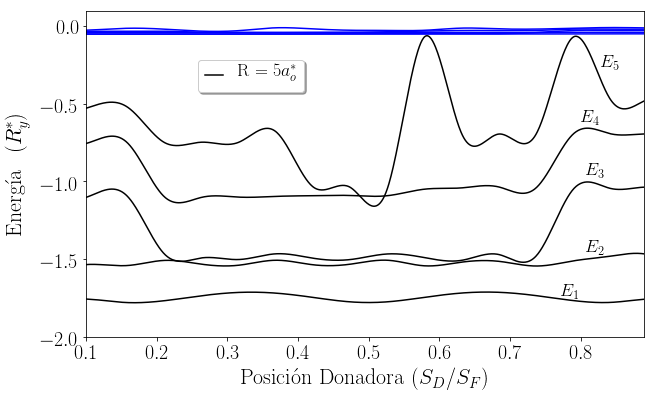

In [269]:
x =  SD_SF_2

y0 =  Ee2[:,0]
y1 =  Ee2[:,1]
y2 =  Ee2[:,2]
y3 =  Ee2[:,3]
y4 =  Ee2[:,4]
y5 =  Ee2[:,5]
y6 =  Ee2[:,6]
y7 =  Ee2[:,7]
y8 =  Ee2[:,8]
y9 =  Ee2[:,9]

t0, c0, k0 = interpolate.splrep(x, y0, s=0, k=3)
t1, c1, k1 = interpolate.splrep(x, y1, s=0, k=3)
t2, c2, k2 = interpolate.splrep(x, y2, s=0, k=3)
t3, c3, k3 = interpolate.splrep(x, y3, s=0, k=3)
t4, c4, k4 = interpolate.splrep(x, y4, s=0, k=3)
t5, c5, k5 = interpolate.splrep(x, y5, s=0, k=3)
t6, c6, k6 = interpolate.splrep(x, y6, s=0, k=3)
t7, c7, k7 = interpolate.splrep(x, y7, s=0, k=3)
t8, c8, k8 = interpolate.splrep(x, y8, s=0, k=3)
t9, c9, k9 = interpolate.splrep(x, y9, s=0, k=3)


N = 1000
xmin, xmax = x.min(), x.max()
xx = np.linspace(xmin, xmax, N)

spline0 = interpolate.BSpline(t0, c0, k0, extrapolate=False)
spline1 = interpolate.BSpline(t1, c1, k1, extrapolate=False)
spline2 = interpolate.BSpline(t2, c2, k2, extrapolate=False)
spline3 = interpolate.BSpline(t3, c3, k3, extrapolate=False)
spline4 = interpolate.BSpline(t4, c4, k4, extrapolate=False)
spline5 = interpolate.BSpline(t5, c5, k5, extrapolate=False)
spline6 = interpolate.BSpline(t6, c6, k6, extrapolate=False)
spline7 = interpolate.BSpline(t7, c7, k7, extrapolate=False)
spline8 = interpolate.BSpline(t8, c8, k8, extrapolate=False)
spline9 = interpolate.BSpline(t9, c9, k9, extrapolate=False)


fig=plt.figure(figsize=(10,6) )#pi=1000)
ax = fig.add_subplot(1, 1, 1)
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')


plt.xlabel(r'Posici\'on Donadora (\textbf{$S_D$}/\textbf{$S_F$})',labelpad=8,fontsize=22,fontweight='bold', horizontalalignment ='center')
plt.ylabel(r'Energ\'ia \,  ($R_y^*$)',labelpad=8,fontsize=22,fontweight='bold', horizontalalignment ='center')


plt.xlim(0.1,0.89)
plt.ylim(-2,0.1)

#plt.annotate('$\\theta\,   = \, \, \pi $', xy=(150, 85), xycoords='figure points',fontsize=24)

plt.annotate(r'\textbf{$E_1$}', xy=(560, 100), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_2$}', xy=(585, 145), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_3$}', xy=(585, 222), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_4$}', xy=(580, 274), xycoords='figure points',fontsize=18)
plt.annotate(r'\textbf{$E_5$}', xy=(600, 330), xycoords='figure points',fontsize=18)

#plt.title('$Caso: R_0= 1 a_0^*$, $\Delta= 0.1 a_0^*$',loc='center',fontsize=20)

plt.plot(xx, spline0(xx), label=' R = $5 a_o^*$', color='black')
plt.plot(xx, spline1(xx), color='black')
plt.plot(xx, spline2(xx), color='black')
plt.plot(xx, spline3(xx), color='black')
plt.plot(xx, spline4(xx), color='black')
plt.plot(xx, spline5(xx), color='b')
plt.plot(xx, spline6(xx), color='b')
plt.plot(xx, spline7(xx), color='b')
plt.plot(xx, spline8(xx), color='b')
plt.plot(xx, spline9(xx), color='b')
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

#plt.axvline(0.2, color='grey', linestyle='--')
#plt.axvline(0.5, color='grey', linestyle='--')
#plt.axvline(0.85, color='grey', linestyle='--')

#plt.grid()
#plt.legend(loc='best')
plt.legend(shadow=True, loc=(0.2,0.75), handlelength=1, fontsize=18)


plt.savefig('R-SR=5.png',format='png', dpi=1000,bbox_inches="tight")
plt.savefig('E-SR=5.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.show()

In [ ]:

R0_a= 2   # Initial Radius of  de Curvature
R0_b= 2
R0_c= 5

DR_a=0.1   # Raise in semi-arc
DR_b=0.2
DR_c=0.2 

R0_a= 2   # Initial Radius of  de Curvature
R0_b= 2
R0_c= 2

DR_a=0.05  # Raise in semi-arc
DR_b=0.1
DR_c=0.3 

R0_a= 2   # Initial Radius of  de Curvature
R0_b= 2
R0_c= 2

DR_a=0.05  # Raise in semi-arc
DR_b=0.1
DR_c=0.3 

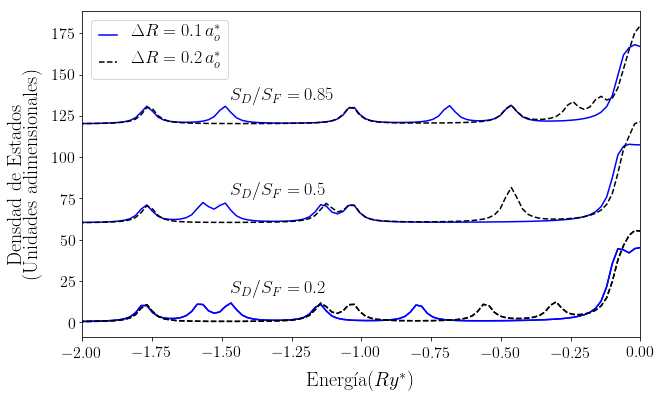

In [171]:
# Instantiate figure and plot

fig = plt.figure( figsize=(10,6) )
#plt.figure(1)

ax = fig.add_subplot(111)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax.set_xlim(-2,0)
#ax.xaxis.set_tick_params(labelsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
R1 = ax.plot(X,F2[:,0],color= 'b',label='$\Delta R= 0.1 \, a_o^*$')
R1 = ax.plot(X,F2[:,0], X,F2[:,1]+ 60,X, F2[:,2] + 2*60,color= 'b')
ax.plot( X,F3[:,0], color= 'black', linestyle='--',label = '$\Delta R= 0.2 \, a_o^*$')
ax.plot( X,F3[:,0],X,F3[:,1]+ 60,X, F3[:,2] + 2*60, color= 'black', linestyle='--')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.annotate('$S_D/S_F = 0.2 $', xy=(230, 102), xycoords='figure points',fontsize=18)
plt.annotate('$S_D/S_F = 0.5 $ ', xy=(230, 200), xycoords='figure points',fontsize=18)
plt.annotate('$S_D/S_F = 0.85 $', xy=(230, 295), xycoords='figure points',fontsize=18)
plt.xlabel(r'Energ\'ia' '($Ry^*$)' , labelpad=10,fontsize=20,fontweight='bold', horizontalalignment='center')           
plt.ylabel(r'Densdad de Estados \\ (Unidades adimensionales)',labelpad=10,fontsize=20,fontweight='bold', horizontalalignment ='center')  
leg1 = ax.legend(loc='upper left', handlelength=1, fontsize=18)

plt.savefig('DOS_DR.pdf',format='pdf', dpi=1000,bbox_inches="tight")
plt.savefig('DOS_DR.png',format='png', dpi=1000,bbox_inches="tight")